<a href="https://colab.research.google.com/github/mavillan/yolanda/blob/main/notebooks/train_lgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
## notebook config

In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install --upgrade kaggle > /dev/null 2>&1
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            35G        1.0G         27G        1.1M        6.3G         33G
Swap:            0B          0B          0B


In [5]:
!pip install --upgrade category_encoders > /dev/null 2>&1
!pip install --upgrade tsforest > /dev/null 2>&1
!pip install --upgrade lightgbm > /dev/null 2>&1

In [ ]:
%%bash
git clone --recursive https://github.com/microsoft/LightGBM ; cd LightGBM
mkdir build
#export CMAKE_CXX_FLAGS='-O3 -mtune=native'
cmake -DUSE_GPU=1
make -j$(nproc)
cd ./python-package/
python setup.py install --precompile

# THIS IS FOR GPU INSTALLATION

In [ ]:
%%bash
git clone --recursive https://github.com/microsoft/LightGBM ; cd LightGBM
mkdir build ; cd build
export CMAKE_CXX_FLAGS='-O3 -mtune=native'
cmake ..
make -j$(nproc)
cd ../python-package/
python setup.py install --precompile

# THIS IS FOR CPU (OPTIMIZED) INSTALLATION

***

In [6]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import stats
import time

import category_encoders as ce
import lightgbm as lgb
from tqdm import tqdm
from tsforest.forecast import LightGBMForecaster

pd.set_option('display.max_columns', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
def reduce_mem_usage(df, verbose=False):
    """
    Utility function to reduce the memory usage of pandas dataframes
    
    Parameters
    ----------
    df: pandas.Dataframe
    verbose: Boolean
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
class RMSSE():
    def __init__(self, valid_dataframe, scales_dataframe):
        self.valid_dataframe = valid_dataframe
        self.scales_dataframe = scales_dataframe
        self.apply_inverse = False
        if set(["y_mean","y_std"]) <= set(valid_dataframe.columns):
            self.apply_inverse = True

    def _evaluate(self, predictions):
        valid_dataframe = self.valid_dataframe.copy()
        if not self.apply_inverse:  
            valid_dataframe["ypred"] = predictions
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y-ypred)**2")
        else:
            valid_dataframe["ypred"] = valid_dataframe["y_std"]*predictions + valid_dataframe["y_mean"]
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y_raw-ypred)**2")
        mse = valid_dataframe.groupby("sku")["sq_error"].mean().reset_index(name="mse")
        mrg = pd.merge(mse, self.scales_dataframe, how="inner", on="sku")
        return mrg.eval("sqrt(mse)/scale").mean()

    def evaluate(self, ypred, dtrain):
        metric = self._evaluate(ypred)
        return "rmsse", metric, False

In [9]:
def ranked_probability_score(y_true, y_pred):
    """
    Input
        y_true: np.array of shape 30. 
        y_pred: np.array of shape 30. 
    """
    return ((y_true.cumsum(axis=1) - y_pred.cumsum(axis=1))**2).sum(axis=1).mean()

def scoring_function(y_true, y_pred):
    """
    Input
        y_true: List of Ints of shape Nx1. Contain the target_stock
        y_pred: List of float of shape Nx30. Contain the prob for each day
    """
    y_true_one_hot = np.zeros_like(y_pred, dtype=np.float64)
    y_true_one_hot[range(len(y_true)), y_true-1] = 1
    return ranked_probability_score(y_true_one_hot, y_pred)

***
## loading data for assessment

In [10]:
!kaggle datasets download -d mavillan/meli-2021 --force --unzip
!ls -halt 

100% 246M/246M [00:02<00:00, 76.6MB/s]

total 370M
drwxr-xr-x 1 root root 4.0K Aug 16 22:37 .
-rw-r--r-- 1 root root 5.7M Aug 16 22:37 validation_seed7.csv
-rw-r--r-- 1 root root 5.7M Aug 16 22:37 validation_seed5.csv
-rw-r--r-- 1 root root 5.7M Aug 16 22:37 validation_seed3.csv
-rw-r--r-- 1 root root 5.7M Aug 16 22:37 validation_seed23.csv
-rw-r--r-- 1 root root 5.7M Aug 16 22:37 validation_seed2.csv
-rw-r--r-- 1 root root 5.7M Aug 16 22:37 validation_seed19.csv
-rw-r--r-- 1 root root 5.7M Aug 16 22:37 validation_seed17.csv
-rw-r--r-- 1 root root 5.7M Aug 16 22:37 validation_seed13.csv
-rw-r--r-- 1 root root 5.7M Aug 16 22:37 validation_seed11.csv
-rw-r--r-- 1 root root 169K Aug 16 22:37 unpredictable.csv
-rw-r--r-- 1 root root  78M Aug 16 22:37 train.parquet
-rw-r--r-- 1 root root 223M Aug 16 22:37 test.parquet
-rw-r--r-- 1 root root 3.3M Aug 16 22:37 skus_for_assess.csv
-rw-r--r-- 1 root root  16M Aug 16 22:37 scales.csv
drwx------ 5 root root 4.0K Aug 16 22:37 drive
drwxr-xr-x 1 ro

In [11]:
scales = pd.read_csv("scales.csv")
skus_for_assess = pd.read_csv("skus_for_assess.csv")

dataset = (
    pd.read_parquet("./train.parquet")
    .query("sku in @skus_for_assess.sku")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .reset_index(drop=True)
)
dataset

,ds,sku,y,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,available,item_domain_id,item_id,site_id,product_id,product_family_id
0,2021-02-01,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
1,2021-02-02,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
2,2021-02-03,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
3,2021-02-04,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
4,2021-02-05,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29179486,2021-03-27,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
29179487,2021-03-28,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
29179488,2021-03-29,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
29179489,2021-03-30,660915,0,99.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None


In [12]:
dataset.groupby("site_id")["sku"].nunique()

site_id
MLA     43314
MLB    252475
MLM    201008
Name: sku, dtype: int64

***
## model config

In [15]:
categorical_features = {
    "sku": ("y", ce.CatBoostEncoder, None),
    "currency": "default",
    "listing_type": "default",
    "shipping_logistic_type": "default",
    "shipping_payment": "default",
    "item_domain_id": ("y", ce.CatBoostEncoder, None),
    "item_id": ("y", ce.CatBoostEncoder, None),
    "site_id":"default",
    "product_id": ("y", ce.CatBoostEncoder, None),
    "product_family_id": ("y", ce.CatBoostEncoder, None),
}

exclude_features = ["fold","sold_quantity",]

model_params = {
    'objective':'tweedie',
    'tweedie_variance_power':1.6,
    #'alpha':1.2,
    'metric':'None',
    'num_iterations':1000,
    'max_bin': 63,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**8-1,
    'min_data_in_leaf': 2**8-1,
    'learning_rate': 0.025,
    'max_delta_step':1.,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'boost_from_average': False,
    'force_row_wise': True,
    'deterministic':True,
    'seed':42,
    #'device_type': 'gpu',
    #'num_gpu' : 1,
}
time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
    #"target_scaler":"standard",
}

***
## model training: assessment

In [16]:
models_by_site = list()
sites = ["MLA","MLB","MLM"]

for site in sites:
    print("-"*75)
    print(f"Preparing model for site: {site}")

    tic = time.time()
    train_data = dataset.query("site_id == @site").reset_index(drop=True)
    valid_idx = train_data.query("ds > '2021-03-01'").index

    model = LightGBMForecaster(**model_kwargs)
    model.prepare_features(train_data, valid_idx)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
    model.fit(fit_kwargs={"verbose_eval":50, "feval":evaluator.evaluate})
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

errors = list()
sites = ["MLA","MLB","MLM"]
for site,model in zip(sites,models_by_site):
    error = model.model.model.best_score["valid_0"]["rmsse"]
    errors.append(error)
result = {
    "rmsse_MLA":errors[0], 
    "rmsse_MLB":errors[1],
    "rmsse_MLM":errors[2],
    "rmsse_AVG":np.mean(errors),
}
display(result)

---------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 124.11 Mb (41.4% reduction)
Mem. usage decreased to 87.98 Mb (51.0% reduction)
Elapsed time for processing features: 0.36772267818450927 min.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 1242194, number of used features: 14
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.799881
[100]	valid_0's rmsse: 0.771457
[150]	valid_0's rmsse: 0.769962
Early stopping, best iteration is:
[127]	valid_0's rmsse: 0.769754
Elapsed time for training the model: 0.7199137409528097 min.
---------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 812.35 Mb (38.7% reduction)
Mem. usage decreased to 512.86 Mb (51.0% reduction)
Elapsed time for processing features: 2.044868731498718 min.
[LightGBM] [Info] Total Bins 501
[LightGBM] [

{'rmsse_AVG': 0.7839018233862286,
 'rmsse_MLA': 0.7697538855803375,
 'rmsse_MLB': 0.8133721109510255,
 'rmsse_MLM': 0.7685794736273226}

In [17]:
all_preds = list()
for site,model in zip(sites,models_by_site):
    preds = model.predict(dataset.query("site_id==@site & ds>'2021-03-01'"))
    all_preds.append(preds)
oof = pd.concat(all_preds, axis=0, ignore_index=True)

In [25]:
class InventoryDaysPredictor():

    def __init__(self, train):
        self.train = train.copy(deep=True)

    def fit(self, preds):
        parameters = self.train.groupby('sku').agg({'y':['mean', 'std']}).y
        # replace nan means by overall mean
        idx = parameters[parameters["mean"].isna()].index 
        parameters.loc[idx, "mean"] = parameters["mean"].mean()
        # replace nan stds by overall std
        idx = parameters[parameters["std"].isna()].index
        parameters.loc[idx,"std"] = parameters["std"].mean()
        self.parameters = parameters.to_dict()

        predictors = dict()
        days = np.arange(1,31)
        for sku,df in tqdm(preds.groupby("sku")):
            cumpred = df.y_pred.values.cumsum()
            interp = interpolate.interp1d(cumpred, days, bounds_error=False, fill_value=(-np.inf,np.inf))
            predictors[sku] = interp
        self.predictors = predictors

    def predict(self, sku, stock):
        mean = self.parameters['mean'][sku]
        std = self.parameters['std'][sku]

        days_to_stockout = float(np.clip(self.predictors[sku](stock), a_min=1, a_max=30))
        std_days = (std / mean) * days_to_stockout
        return days_to_stockout, std_days

    def calc_probs(self, norm_dist):
        days = np.arange(1,31)
        probs = norm_dist.pdf(days)
        
        #if prob is zero, replace with uniform
        if np.sum(probs) == 0:
            return np.ones(30) / 30

        probs = probs / np.sum(probs)
        return probs

    def predict_proba(self, sku, stock):
        days_to_stockout, std_days = self.predict(sku, stock)
        norm_dist = stats.norm(days_to_stockout, std_days)
        return self.calc_probs(norm_dist)

In [26]:
predictor = InventoryDaysPredictor(dataset.query("ds <= '2021-03-01'"))
predictor.fit(oof)

100%|██████████| 496797/496797 [01:22<00:00, 6004.75it/s]


In [27]:
# assessment of inventory_days prediction
valid = pd.read_csv("./validation_seed2.csv")

preds = list()
for sku,df in tqdm(valid.groupby("sku")):
    preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
preds = pd.DataFrame(preds, columns=["days_to_stockout"])

100%|██████████| 496797/496797 [01:26<00:00, 5760.29it/s]


RMSE (mean):  10.512693130490346
RMSE (median):  6.0
MAE (mean):  7.909787425190221
MAE (median):  6.0


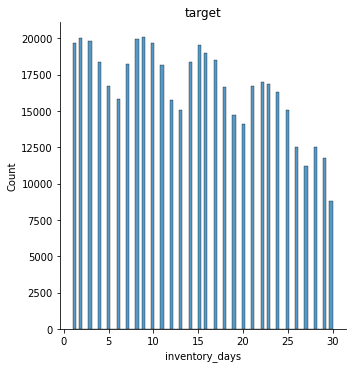

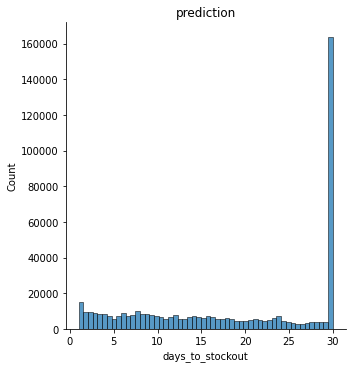

In [28]:
# tweedie loss
print("RMSE (mean): ", np.sqrt(np.mean((preds.days_to_stockout - valid.inventory_days)**2)) )
print("RMSE (median): ", np.sqrt(np.median((preds.days_to_stockout - valid.inventory_days)**2)) )
print("MAE (mean): ", np.mean(np.abs(preds.days_to_stockout - valid.inventory_days)))
print("MAE (median): ", np.median(np.abs(preds.days_to_stockout - valid.inventory_days)))

sns.displot(valid.inventory_days)
plt.title("target")
plt.show()

sns.displot(preds.days_to_stockout)
plt.title("prediction")
plt.show()

RMSE (mean):  11.462373485367673
RMSE (median):  6.751870251624625
MAE (mean):  8.74472550557678
MAE (median):  6.751870251624625


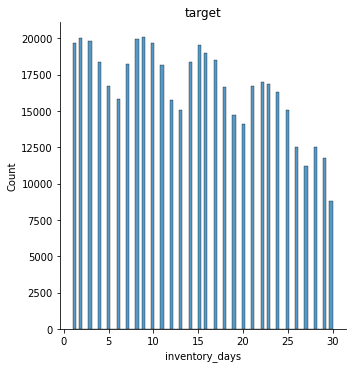

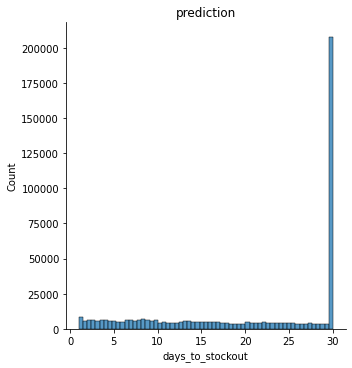

In [41]:
# huber loss
print("RMSE (mean): ", np.sqrt(np.mean((preds.days_to_stockout - valid.inventory_days)**2)) )
print("RMSE (median): ", np.sqrt(np.median((preds.days_to_stockout - valid.inventory_days)**2)) )
print("MAE (mean): ", np.mean(np.abs(preds.days_to_stockout - valid.inventory_days)))
print("MAE (median): ", np.median(np.abs(preds.days_to_stockout - valid.inventory_days)))

sns.displot(valid.inventory_days)
plt.title("target")
plt.show()

sns.displot(preds.days_to_stockout)
plt.title("prediction")
plt.show()

***

In [29]:
results = list()

for files in glob("./validation_seed*.csv")[:3]:
    valid = pd.read_csv(files)

    preds_proba = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds_proba.append(predictor.predict_proba(sku, df.target_stock.values[0]))
    preds_proba = np.array(preds_proba)
    
    rps = scoring_function(valid.inventory_days.values, preds_proba)
    results.append({"file":files.split("/")[-1].split(".")[0], "rps":rps})
    print({"file":files.split("/")[-1].split(".")[0], "rps":rps})

100%|██████████| 496797/496797 [09:35<00:00, 863.37it/s]


{'file': 'validation_seed17', 'rps': 4.144744792191483}


100%|██████████| 496797/496797 [09:29<00:00, 872.56it/s]


{'file': 'validation_seed19', 'rps': 4.137523467669764}


100%|██████████| 496797/496797 [09:29<00:00, 871.91it/s]


{'file': 'validation_seed2', 'rps': 4.140724628030401}


In [30]:
pd.DataFrame(results)

,file,rps
0,validation_seed17,4.144745
1,validation_seed19,4.137523
2,validation_seed2,4.140725


***